In [1]:
%load_ext lab_black

In [2]:
%load_ext autoreload
%autoreload 2

For this stage, we will fit 2 models to use as benchmark models:

* **First model**: We will fit a linear regression with all the features, only performing a standard scaling.
* **Second model**: we will perform a power transformation to obtain gaussian variables and then proceed with a feature selection to identify the ost relevant variables

For both models, we will use the iterative imputer provided by scikit-learn to fill NaN's that are present.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import (
    RFE,
    SelectKBest,
    mutual_info_regression,
    f_regression,
)
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    RepeatedKFold,
    GridSearchCV,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler


from urbana.features import normaltests
from urbana.constants import DIR_REPO, DIR_DATA
from urbana.models.plot_predictions import PredictedAccuracy

cmap = sns.diverging_palette(230, 20, as_cmap=True)

In [4]:
# papermill parameters cell
# https://papermill.readthedocs.io/en/latest/usage-parameterize.html

OUTPUT_WARNINGS = False
VARIABLE_TO_PREDICT = "Airbnb_Number"

In [5]:
if not OUTPUT_WARNINGS:
    import warnings

    warnings.filterwarnings("ignore")

In [6]:
np.random.seed(42)

sect = pd.read_csv(
    DIR_DATA / "interim/sections.csv",
)

sect.set_index("Tag", inplace=True)

sect.drop(["N_district", "N_neighbourhood", "N_section"], axis=1, inplace=True)

In [7]:
X = sect.drop([VARIABLE_TO_PREDICT], axis=1)
y = sect[VARIABLE_TO_PREDICT]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# First model: All features

## Pipeline fit

In [8]:
pipe_all = Pipeline(
    steps=[
        ("imputer", IterativeImputer()),
        ("regressor", LinearRegression()),
    ]
)

In [9]:
pipe_all.fit(X_train, y_train)

y_test_pred_all = pipe_all.predict(X_test)

## Prediction plot

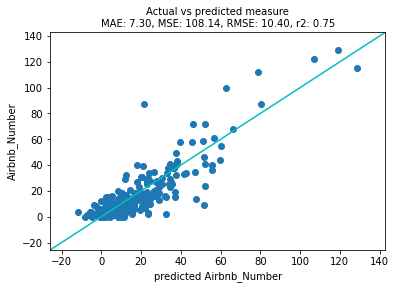

In [10]:
pa_all = PredictedAccuracy(y_test, y_test_pred_all)
pa_all.plot_scatter()

## Sensitivity analysis

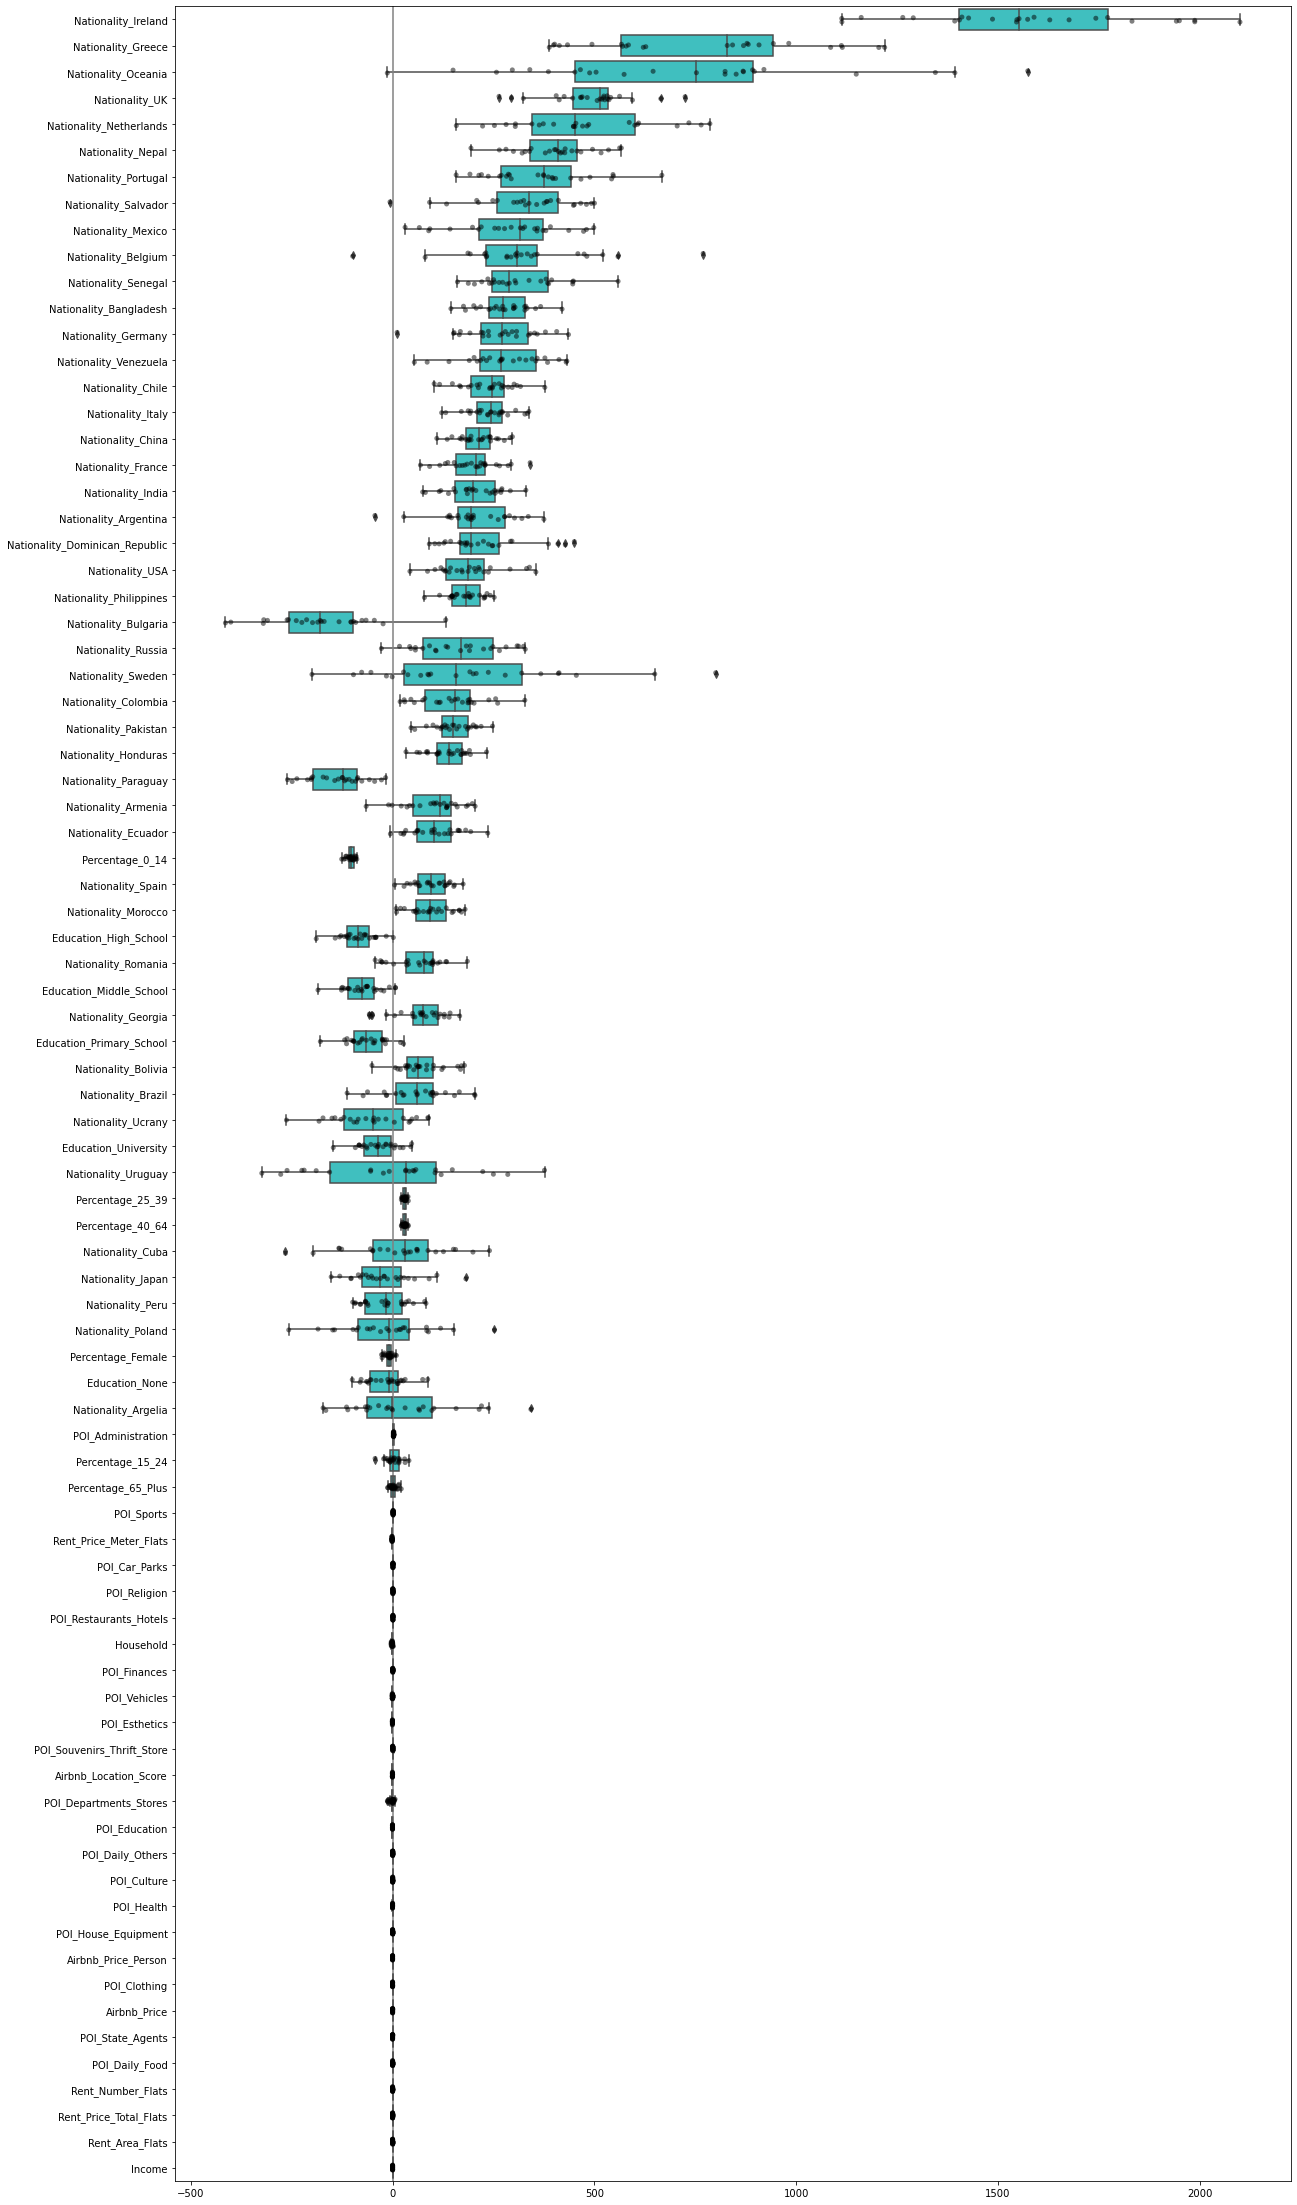

In [11]:
cv_all = cross_validate(
    pipe_all,
    X,
    y,
    cv=RepeatedKFold(n_splits=5, n_repeats=5),
    scoring=["neg_root_mean_squared_error"],
    return_estimator=True,
    n_jobs=-1,
)

coefs_all = pd.DataFrame(
    [est.named_steps["regressor"].coef_ for est in cv_all["estimator"]],
    columns=X.columns,
)

medians_all = coefs_all.median()
medians_all = medians_all.reindex(medians_all.abs().sort_values(ascending=False).index)
coefs_all = coefs_all[medians_all.index]


plt.figure(figsize=(20, 40))
sns.stripplot(data=coefs_all, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs_all, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")

# Second model: Transformations and feature selection

In [12]:
# Drop variables that we have checked are not useful

sect.drop(["Percentage_40_64", "Income"], axis=1, inplace=True)

# Divide in train and test

X = sect.drop([VARIABLE_TO_PREDICT], axis=1)
y = sect[VARIABLE_TO_PREDICT]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Normality tests

In [13]:
# # Generate a report

# profile = ProfileReport(sect, title="EDA_Barcelona", minimal=True)
# profile

In [14]:
# Check which variables are already normal
normality_test = normaltests.get_normaltest_df(X_train.T)

print(normality_test["dagostino"].value_counts())
print(normality_test["shapiro"].value_counts())

False    81
Name: dagostino, dtype: int64
False    81
Name: shapiro, dtype: int64


## Preprocessing Pipeline

The preprocessing will have two phases:
* IterativeImputer: To imput missing data by fitting models (better than imputing the mean or the median)
* PowerTransformer: Since none of the features is Gaussian, we will transform them with the *Yeo-Johnson* transformation

In [15]:
preprocessor = Pipeline(
    steps=[("imputer", IterativeImputer()), ("pt", PowerTransformer())]
)

## Feature Selection Pipeline

In order to perform a feature selection, we will use *RFE* (Recursive Feature Elimination).

The number of variables to use will be a hyper-paramater that will be tuned with a GridSearch using RMSE as the metric.

The target feature will also be transformed with a PowerTransfomrer, by applying the *TransformedTargetRegressor*.

In [16]:
# Define the regressor to use
myRegressor = LinearRegression()

# Define a pipeline with the preprocessing, feature selection (RFE) and regressor
pipe_rfe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("rfe", RFE(estimator=myRegressor)),
        ("regressor", myRegressor),
    ]
)

# Define the param space for hyper-parameter tunning (in this case, the number of features to keep with RFE)
param_grid_rfe = [{"rfe__n_features_to_select": np.arange(25, 30, 1)}]

search_rfe = GridSearchCV(
    pipe_rfe, param_grid_rfe, scoring="neg_root_mean_squared_error", n_jobs=-1
)


model = TransformedTargetRegressor(regressor=search_rfe, transformer=PowerTransformer())

model.fit(X_train, y_train)

TransformedTargetRegressor(regressor=GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                                                             Pipeline(steps=[('imputer',
                                                                                              IterativeImputer()),
                                                                                             ('pt',
                                                                                              PowerTransformer())])),
                                                                            ('rfe',
                                                                             RFE(estimator=LinearRegression())),
                                                                            ('regressor',
                                                                             LinearRegression())]),
                                                  n_jobs=-1,
                     

In [17]:
print("Best Model:")
print(
    "Number of features: "
    + str(model.regressor_.best_params_["rfe__n_features_to_select"])
)
print("\nList of features:")
cols_rfe = model.regressor_.best_estimator_.named_steps["rfe"].get_support(indices=True)
print(X.columns[cols_rfe])

Best Model:
Number of features: 27

List of features:
Index(['POI_House_Equipment', 'POI_Education', 'POI_Restaurants_Hotels',
       'Airbnb_Price', 'Airbnb_Price_Person', 'Airbnb_Location_Score',
       'Percentage_0_14', 'Percentage_25_39', 'Education_None',
       'Education_Primary_School', 'Education_Middle_School',
       'Education_University', 'Nationality_Spain', 'Nationality_Italy',
       'Nationality_France', 'Nationality_UK', 'Nationality_Germany',
       'Nationality_Portugal', 'Nationality_Morocco', 'Nationality_Honduras',
       'Nationality_Argentina', 'Nationality_China', 'Nationality_Bangladesh',
       'Nationality_Armenia', 'Rent_Number_Flats', 'Rent_Price_Meter_Flats',
       'Rent_Area_Flats'],
      dtype='object')


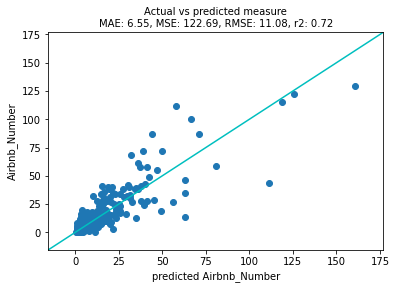

In [18]:
y_test_pred_rfe = model.predict(X_test)
pa_rfe = PredictedAccuracy(y_test, y_test_pred_rfe)
pa_rfe.plot_scatter()

# Sensitivity Analysis

In [19]:
X_train_rfe = X_train.iloc[:, cols_rfe]
X_rfe = X.iloc[:, cols_rfe]

pipe_sens = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", myRegressor)])

model_sens = TransformedTargetRegressor(
    regressor=pipe_sens, transformer=PowerTransformer()
)

model_sens.fit(X_train_rfe, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      Pipeline(steps=[('imputer',
                                                                       IterativeImputer()),
                                                                      ('pt',
                                                                       PowerTransformer())])),
                                                     ('regressor',
                                                      LinearRegression())]),
                           transformer=PowerTransformer())

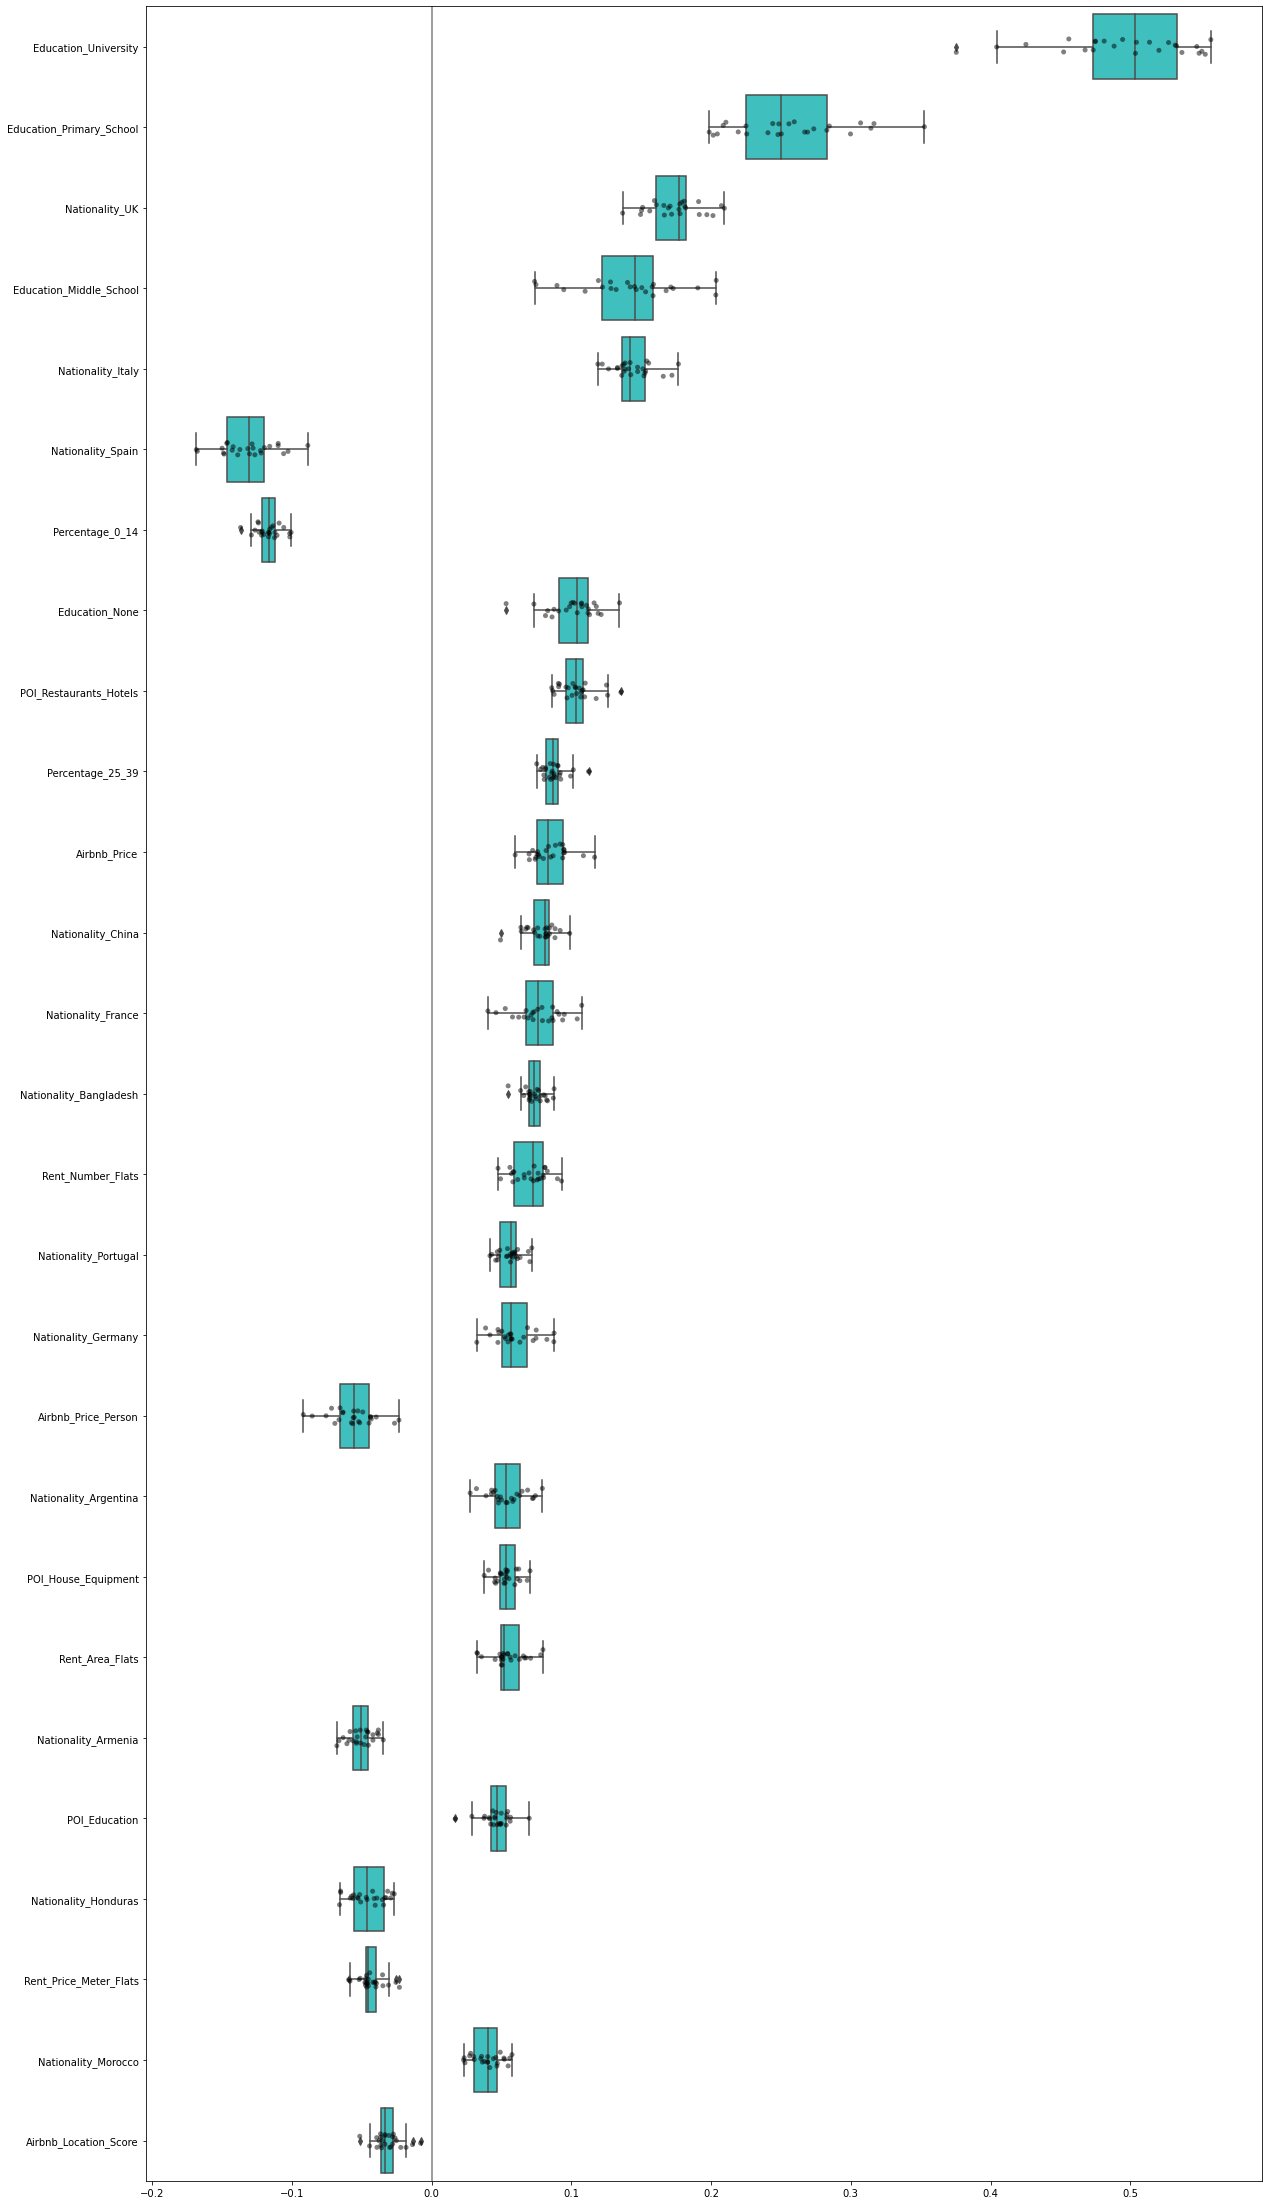

In [20]:
cv_rfe = cross_validate(
    model_sens,
    X_rfe,
    y,
    cv=RepeatedKFold(n_splits=5, n_repeats=5),
    scoring=["neg_root_mean_squared_error"],
    return_estimator=True,
    n_jobs=-1,
)

coefs_rfe = pd.DataFrame(
    [est.regressor_.named_steps["regressor"].coef_ for est in cv_rfe["estimator"]],
    columns=X_rfe.columns,
)

medians_rfe = coefs_rfe.median()
medians_rfe = medians_rfe.reindex(medians_rfe.abs().sort_values(ascending=False).index)
coefs_rfe = coefs_rfe[medians_rfe.index]


plt.figure(figsize=(20, 40))
sns.stripplot(data=coefs_rfe, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs_rfe, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")